In [1]:
!pip install -q transformers==4.2.0
!pip install -q biopython
!pip install -q sklearn_crfsuite

In [2]:
%run error_paragraph.ipynb

In [3]:
label_map = {'B-currency': 11,
 'I-rate': 10,
 'I-item': 8,
 'I-benefit': 4,
 'B-parameter': 5,
 'B-Heading': 1,
 'B-item': 7,
 'I-Heading': 2,
 'B-rate': 9,
 'I-currency': 12,
 'I-parameter': 6,
 'B-benefit': 3,
 'o': 0}

key_list=list(label_map.keys())
value_list=list(label_map.values())

In [4]:
import os
def load_test_file():

    test_file_list = list()
    
    for root, dirs, files in os.walk("raw_data/test"):
        test_file_list = files
        break
    
    print("find files below:")
    for i in range(len(test_file_list)):
        print((i+1), ". ", test_file_list[i])
    return test_file_list

In [5]:
import csv
def take_tokens_and_labels(test_file):
    

    sentences = []
    labels = []
    tokens = []
    token_labels = []
    unique_labels = set()

    with open("raw_data/test/%s" % test_file, newline = '') as lines:                                                                                                 

        line_reader = csv.reader(lines, delimiter='\t')

        for line in line_reader:
            if line == []:
                if tokens:
                    sentences.append(tokens)
                    labels.append(token_labels)          

                tokens = []
                token_labels = []        

            else: 
                if not line[1]==' ':
                    tokens.append(line[1])
                    token_labels.append(line[0])
                    unique_labels.add(line[0])

    return sentences, labels, tokens, token_labels, unique_labels

In [6]:
!pip install transformers
from transformers import BertTokenizer
def retokenize(sentences):
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    
    input_ids = []
    attention_masks = []

    for sent in sentences:

        sent_str = ' '.join(sent)

        encoded_dict = tokenizer.encode_plus(sent_str,
                                             add_special_tokens = True,
                                             max_length = 500,
                                             pad_to_max_length = True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt')
   
        input_ids.append(encoded_dict['input_ids'][0])

        attention_masks.append(encoded_dict['attention_mask'][0])

    return input_ids, attention_masks, tokenizer

In [7]:
def turn_to_new_labels(input_ids, labels, label_map, tokenizer):

    new_labels = []

    null_label_id = -100

    for (sen, orig_labels) in zip(input_ids, labels):

        padded_labels = []

        orig_labels_i = 0 

        for token_id in sen:

            token_id = token_id.numpy().item()

            if (token_id == tokenizer.pad_token_id) or \
                (token_id == tokenizer.cls_token_id) or \
                (token_id == tokenizer.sep_token_id):

                padded_labels.append(null_label_id)

            else:

                label_str = orig_labels[orig_labels_i]
                padded_labels.append(label_map[label_str])

                orig_labels_i += 1

        assert(len(sen) == len(padded_labels))    

        new_labels.append(padded_labels)
        
    return new_labels

In [8]:
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
def creat_dataloader(input_ids, attention_masks, new_labels):

    pt_input_ids = torch.stack(input_ids, dim=0)
    pt_attention_masks = torch.stack(attention_masks, dim=0)
    pt_labels = torch.tensor(new_labels, dtype=torch.long)
 
    batch_size = 16

    prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    
    return prediction_dataloader

In [9]:
import torch.nn as nn
def prediction(prediction_dataloader, model):

    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = nn.DataParallel(model)
    model.to(device)
    model.cuda()

    predictions , true_labels = [], []

    for batch in prediction_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            result = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask,
                          return_dict=True)

        logits = result.logits
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)
        
    return predictions, true_labels

In [10]:
def flatten(predictions, true_labels):

    all_predictions = np.concatenate(predictions, axis=0)
    all_true_labels = np.concatenate(true_labels, axis=0)

    predicted_label_ids = np.argmax(all_predictions, axis=2)
    
    return all_true_labels, predicted_label_ids, all_predictions

In [11]:
def predict_prob(all_predictions):
    prob = []
    for i in range(all_predictions.shape[0]):
        prob.append(all_predictions[i].tolist())

    return prob

In [12]:
#!pip install biopython

import copy
from Bio import File

def export_result(sentences, value_list, test_file, all_true_labels, predicted_label_ids, key_list, prob):

    cpy_sentences=copy.deepcopy(sentences)


    csv_file = open("raw_data/test_predict/%s.csv" % test_file[0:-4],'w', encoding = "utf-8-sig")
    csv_file.write('text,true,predict,o,B-Heading,I-Heading,B-benefit,I-benefit,B-parameter,I-parameter,B-item,I-item,B-rate,I-rate,B-currency,I-currency\n')
    
    for i in range(len(all_true_labels)):
        ins_sentences=cpy_sentences[i]
        ins_sentences.insert(0,'')
  
        for tl,pl,sen, probiblity in zip(all_true_labels[i],predicted_label_ids[i],np.array(ins_sentences), prob[i]):
            if not tl==-100:
                csv_file.write('{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15}\n'
                           .format(sen,key_list[value_list.index(tl)],key_list[value_list.index(pl)],
                                   round(probiblity[0],2),round(probiblity[1],2),round(probiblity[2],2),round(probiblity[3],2),
                                   round(probiblity[4],2),round(probiblity[5],2),round(probiblity[6],2),round(probiblity[7],2),
                                   round(probiblity[8],2),round(probiblity[9],2),round(probiblity[10],2),round(probiblity[11],2),
                                   round(probiblity[12],2)))
            
        csv_file.write('\n')
    csv_file.close()
    
    cpy_sentences=copy.deepcopy(sentences)
    
    bio_file = open("raw_data/test_predict/%s" % test_file,'w', encoding = "utf-8")
    for i in range(len(all_true_labels)):
        ins_sentences=cpy_sentences[i]
        ins_sentences.insert(0,'')

        for tl,pl,sen in zip(all_true_labels[i],predicted_label_ids[i],np.array(ins_sentences)):
            if not tl==-100:
                bio_file.write('{0}\t{1}\n'.format(key_list[value_list.index(pl)], sen))
        bio_file.write('\n')
    bio_file.close()

In [13]:
#!pip install -q sklearn_crfsuite
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluation(predicted_label_ids, all_true_labels):
    
    predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)

    real_token_predictions = []
    real_token_labels = []

    for i in range(len(all_true_labels)):

        if not all_true_labels[i] == -100:

            real_token_predictions.append(predicted_label_ids[i])
            real_token_labels.append(all_true_labels[i])

    f1 = f1_score(real_token_labels, real_token_predictions, average='micro')
    print("F1 score: {:.2%}".format(f1))

    inv_label_map = dict(zip(value_list, key_list))
    
    inv_real_token_labels = []
    inv_real_token_predictions = []
    for i in range(len(real_token_labels)):
        inv_real_token_labels.append(inv_label_map[real_token_labels[i]])
    for i in range(len(real_token_predictions)):
        inv_real_token_predictions.append(inv_label_map[real_token_predictions[i]])
    
    
    
    matrix = confusion_matrix(inv_real_token_labels, inv_real_token_predictions)
    
    new_value_list = []
    for i in value_list:
        if i in list(predicted_label_ids):
            new_value_list.append(inv_label_map[i])
        else:
            if i in (all_true_labels):
                new_value_list.append(inv_label_map[i])

    new_value_list.sort()
    f, ax= plt.subplots(figsize = (18, 8))
    ax.set_title('Confusion matrix', fontsize = 30)
    sns.set(font_scale=1.5)
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=new_value_list, yticklabels=new_value_list)
    ax.invert_yaxis()
    plt.xlabel("Predicted_label", fontsize = 25)
    plt.ylabel("Real_label", fontsize = 25)
    plt.show()

find files below:
1 .  label_民利旺_0306C.bio
2 .  label_美滿傳家_0306.bio
3 .  label_美鑽奇積_new_c0306.bio
4 .  label_ 利多桓年_0306C.bio
5 .  label_樂退年年_0306C.bio

Start to predict label_民利旺_0306C.bio!


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


F1 score: 99.58%


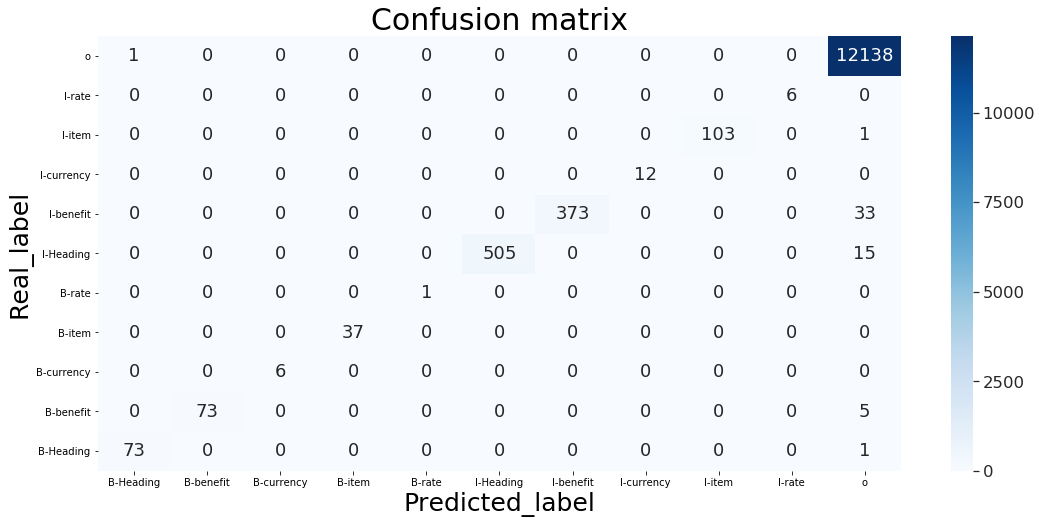

label_民利旺_0306C.bio is done!

Start to predict label_美滿傳家_0306.bio!


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


F1 score: 99.86%


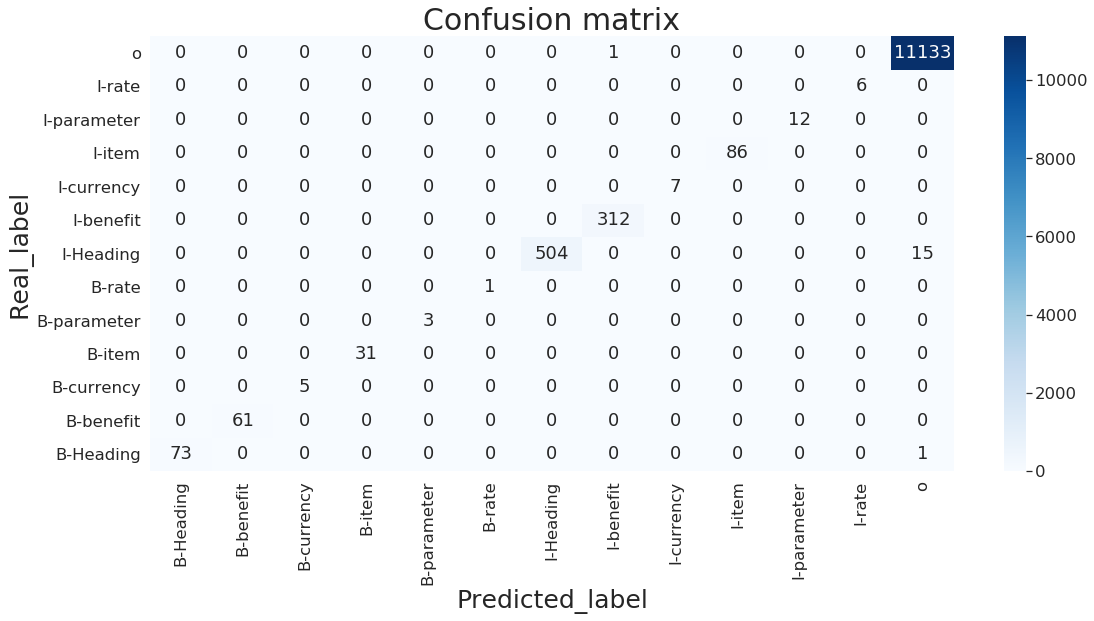

label_美滿傳家_0306.bio is done!

Start to predict label_美鑽奇積_new_c0306.bio!


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


F1 score: 99.78%


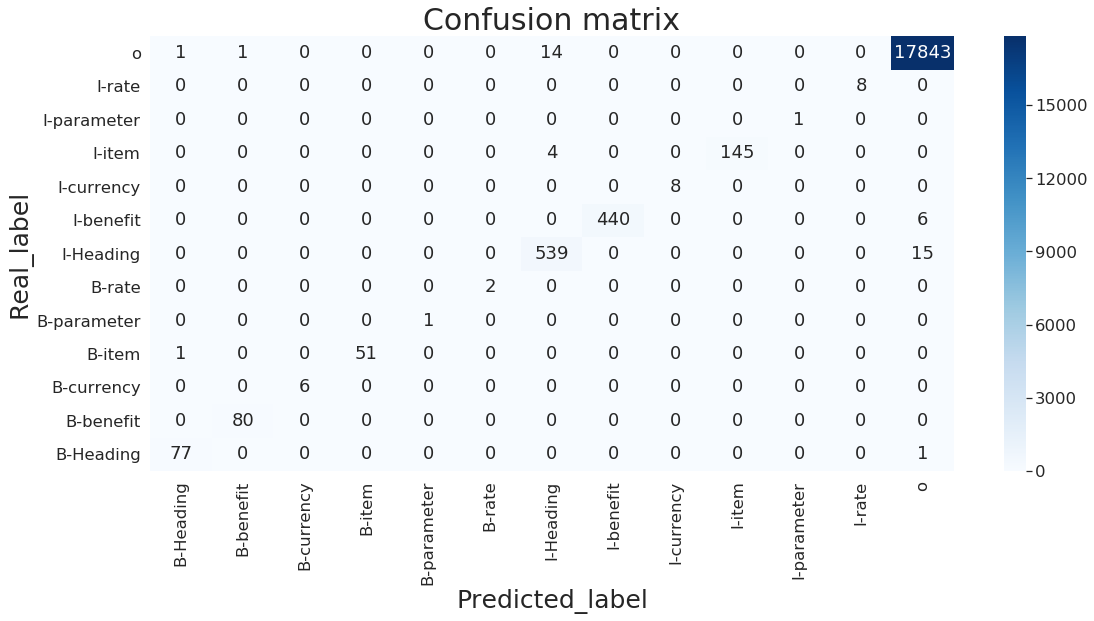

label_美鑽奇積_new_c0306.bio is done!

Start to predict label_ 利多桓年_0306C.bio!


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


F1 score: 99.96%


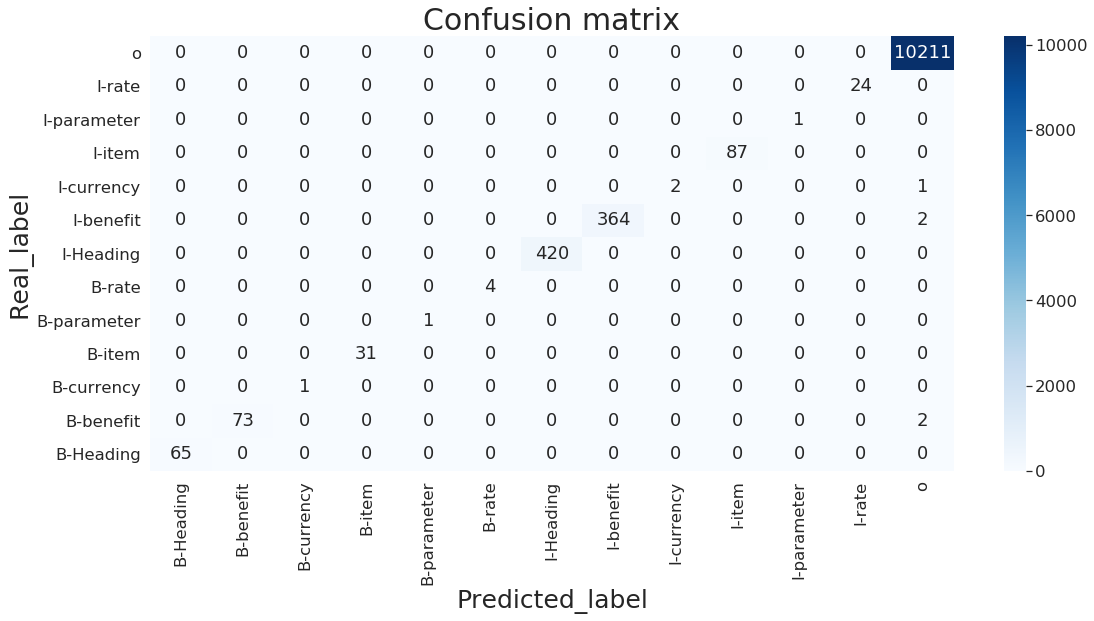

label_ 利多桓年_0306C.bio is done!

Start to predict label_樂退年年_0306C.bio!


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


F1 score: 99.71%


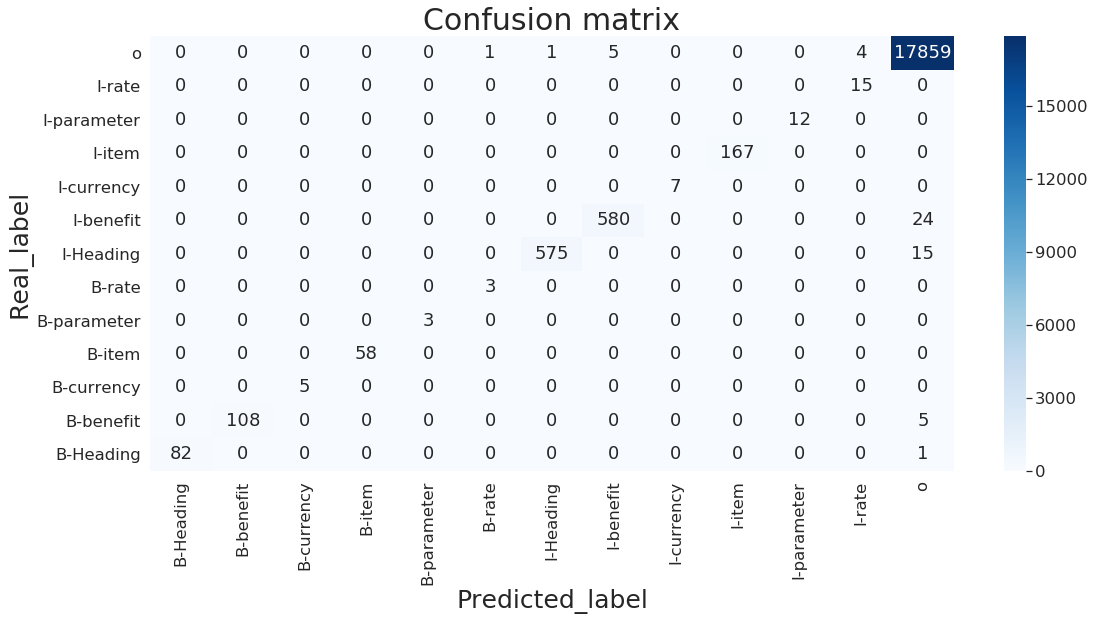

label_樂退年年_0306C.bio is done!

-----Finish-----


In [14]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from transformers import BertForTokenClassification
model = BertForTokenClassification.from_pretrained('./model_save/', output_attentions=True)
assert model.config.output_attentions == True

test_file_list = load_test_file()
for test_file in test_file_list:

    print("\nStart to predict %s!" % test_file)
    
    sentences, labels, tokens, token_labels, unique_labels = take_tokens_and_labels(test_file)
    
    input_ids, attention_masks, tokenizer = retokenize(sentences)
    
    new_labels = turn_to_new_labels(input_ids, labels, label_map, tokenizer)
    
    prediction_dataloader = creat_dataloader(input_ids, attention_masks, new_labels)
    
    predictions, true_labels = prediction(prediction_dataloader, model)
    
    all_true_labels, predicted_label_ids, all_predictions = flatten(predictions, true_labels)
    
    prob = predict_prob(all_predictions)
    
    export_result(sentences, value_list, test_file, all_true_labels, predicted_label_ids, key_list, prob)
    
    evaluation(predicted_label_ids, all_true_labels)
    
    print("%s is done!" % test_file)
    
print("\n-----Finish-----")

In [15]:
file_path_list = list()
file_name_list = list()
file_path_list, file_name_list = catch_csv()
for file_path, file_name in zip(file_path_list, file_name_list):
    catch_fail_paragraph(file_path, file_name)

轉換完成：analysis_label_樂退年年_0306C.csv

轉換完成：analysis_label_美鑽奇積_new_c0306.csv

轉換完成：analysis_label_民利旺_0306C.csv

轉換完成：analysis_label_美滿傳家_0306.csv

轉換完成：analysis_label_ 利多桓年_0306C.csv

